In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from pmdarima.arima import auto_arima
import emd
from matplotlib import rcParams

In [2]:
plt.style.use('ggplot')
rcParams['figure.figsize'] = 12, 5
rcParams['pdf.fonttype'] = 3
rcParams['font.size'] = 8
rcParams['axes.linewidth'] = 1

In [3]:
df = pd.read_csv('./../data/weather_dataset_preprocesado.csv')
target_column = 'T (degC)'
target_index = 'datetime'
load = df[target_column]
time = df[target_index]
x_label = 'Time'
y_label = 'Temperature (°C)'

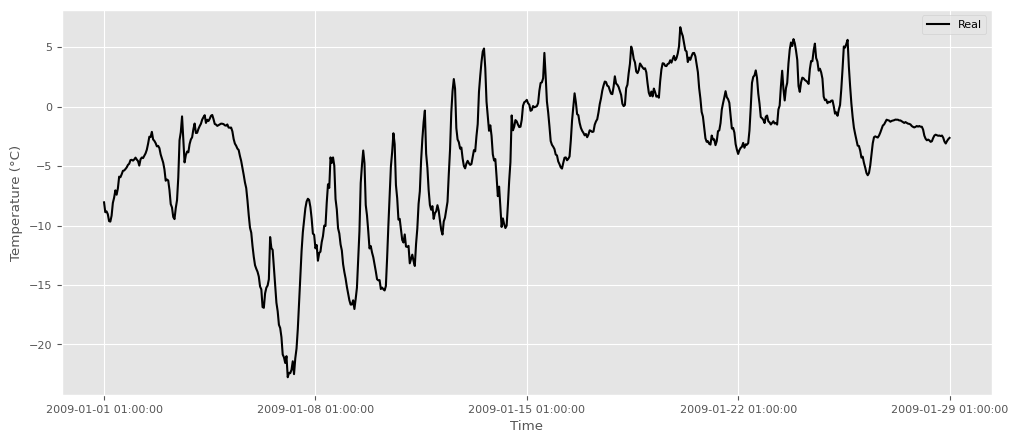

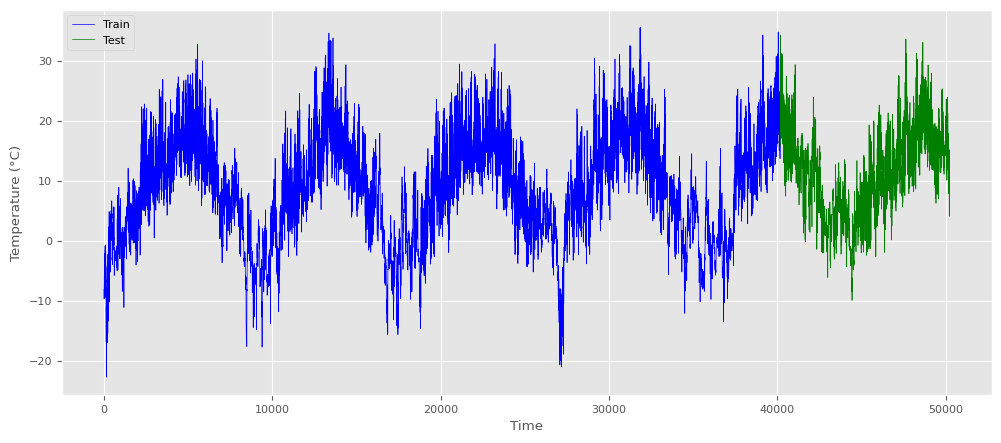

,lag1,lag2,lag3
0,-8.05,-8.05,-8.05
1,-8.05,-8.05,-8.05
2,-8.88,-8.05,-8.05
3,-8.81,-8.88,-8.05
4,-9.05,-8.81,-8.88
...,...,...,...
40174,22.40,23.72,26.45
40175,20.36,22.40,23.72
40176,19.28,20.36,22.40
40177,18.88,19.28,20.36


,lag1,lag2,lag3
40179,15.89,15.89,15.89
40180,15.89,15.89,15.89
40181,16.37,15.89,15.89
40182,18.50,16.37,15.89
40183,21.14,18.50,16.37
...,...,...,...
50219,13.17,10.36,8.01
50220,13.69,13.17,10.36
50221,14.19,13.69,13.17
50222,14.99,14.19,13.69


In [4]:
plt.plot(time[:673], load[:673], color='k', label='Real')
plt.xticks(np.arange(0, 673, step=168))
plt.xlabel(xlabel=x_label)
plt.ylabel(ylabel=y_label)
plt.legend()
plt.show()

train = load[:int(len(load) * 0.8)]
test = load[int(len(load) * 0.8):]
plt.plot(train, label='Train', color='b', linewidth=0.5)
plt.plot(test, label='Test', color='g', linewidth=0.5)
plt.xlabel(xlabel=x_label)
plt.ylabel(ylabel=y_label)
plt.legend()
plt.show()

df_train = pd.DataFrame(train)
df_test = pd.DataFrame(test)
for i in range(1, 4):
    df_train["lag{}".format(i)] = df_train[target_column].shift(i)
    df_test["lag{}".format(i)] = df_test[target_column].shift(i)

df_train = df_train.bfill().drop(columns=[target_column])
df_test = df_test.bfill().drop(columns=[target_column])
display(df_train, df_test)

<Axes: xlabel='Time (samples)'>

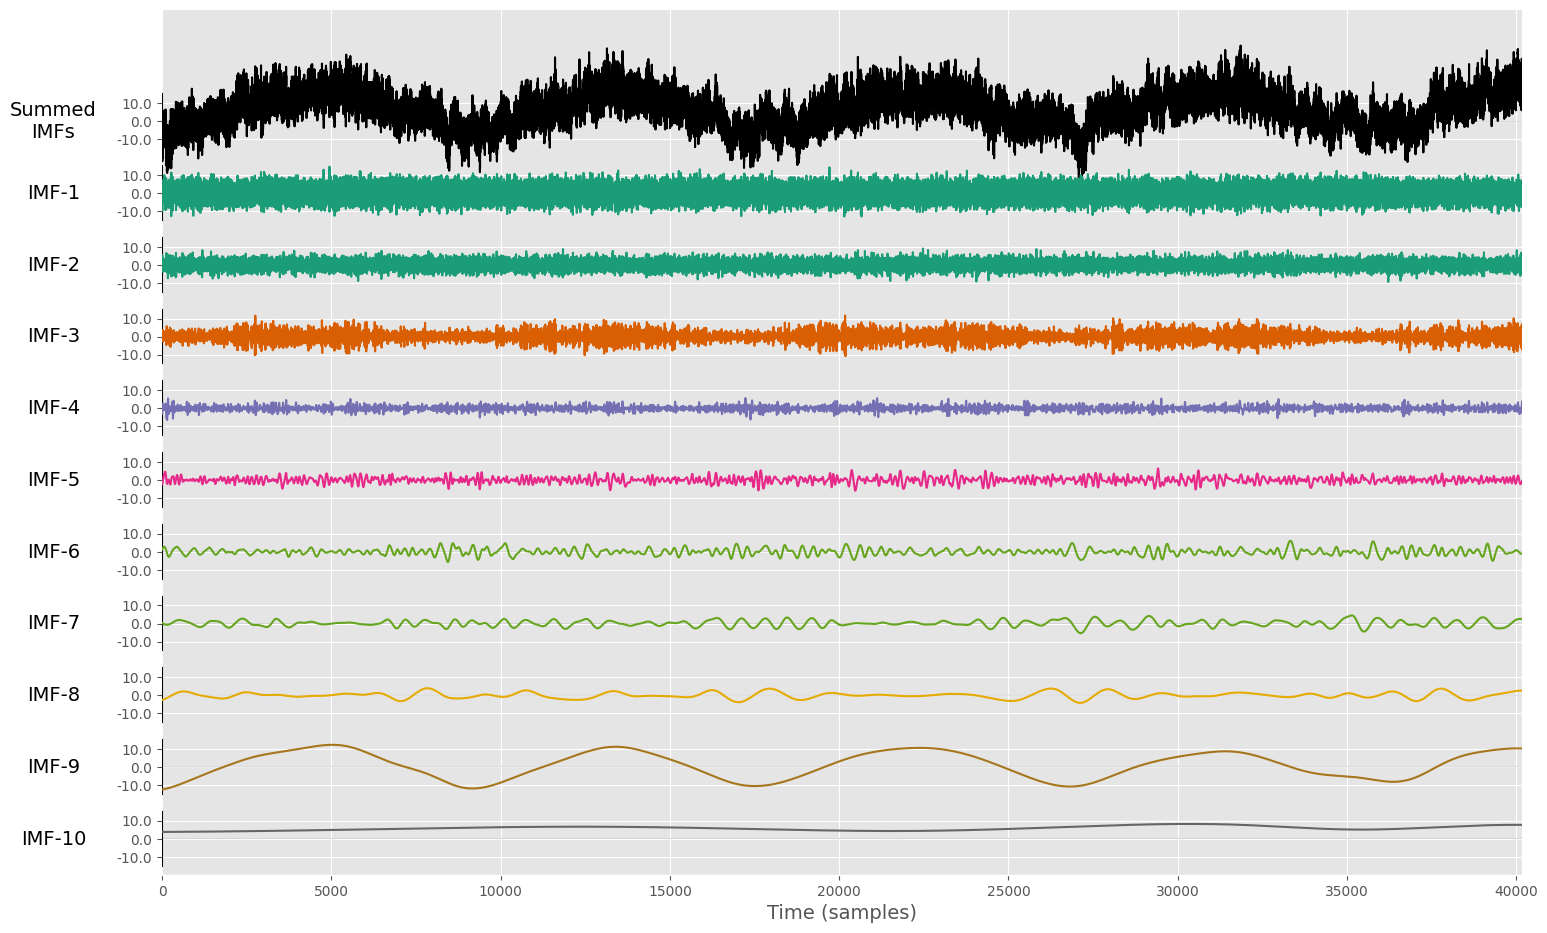

In [5]:
imf_eemd = emd.sift.ensemble_sift(np.array(train), nensembles=4, nprocesses=6, ensemble_noise=1, imf_opts={'sd_thresh': 0.1})
emd.plotting.plot_imfs(imf_eemd)

In [6]:
imf_eemd_df = pd.DataFrame(data=imf_eemd)
imf_eemd_df.columns = ['imf_eemd_{}'.format(i+1) for i in range(imf_eemd.shape[1])]
display(imf_eemd_df)

,imf_eemd_1,imf_eemd_2,imf_eemd_3,imf_eemd_4,imf_eemd_5,imf_eemd_6,imf_eemd_7,imf_eemd_8,imf_eemd_9,imf_eemd_10
0,6.583399,-1.098560,-0.014937,-2.994711,-2.248701,1.379828,0.343770,-2.581470,-12.462107,3.754846
1,-8.999793,2.893429,-0.075975,-2.811846,-2.191376,1.410490,0.329562,-2.576264,-12.458786,3.754948
2,-2.954870,5.506758,-0.069548,-2.579704,-2.126388,1.441439,0.315428,-2.571015,-12.455455,3.755049
3,6.821145,4.837462,-0.075412,-2.304726,-2.054116,1.472653,0.301368,-2.565723,-12.452114,3.755151
4,-9.908798,1.369491,-0.157589,-1.993881,-1.975018,1.504108,0.287383,-2.560387,-12.448762,3.755253
...,...,...,...,...,...,...,...,...,...,...
40174,-0.838908,0.235279,-4.640933,3.829245,-0.617053,-1.057893,2.436475,2.559467,10.239178,7.671064
40175,-2.216544,-0.645999,-6.070024,3.906247,-0.593890,-1.051461,2.433599,2.559062,10.238367,7.670897
40176,2.394573,-2.355615,-6.992841,3.954135,-0.573040,-1.044653,2.430691,2.558641,10.237552,7.670729
40177,2.973310,-3.560341,-7.339786,3.971487,-0.554602,-1.037471,2.427751,2.558205,10.236730,7.670560


In [7]:
from statsmodels.tsa.arima.model import ARIMA

imf1_eemd_arima = ARIMA(imf_eemd_df['imf_eemd_1'], order=(2, 1, 5)).fit()
imf1_eemd_arima_fc = imf1_eemd_arima.forecast(steps=len(test))

imf2_eemd_arima = ARIMA(imf_eemd_df['imf_eemd_2'], order=(2, 1, 5)).fit()
imf2_eemd_arima_fc = imf2_eemd_arima.forecast(steps=len(test))

imf3_eemd_arima = ARIMA(imf_eemd_df['imf_eemd_3'], order=(2, 1, 5)).fit()
imf3_eemd_arima_fc = imf3_eemd_arima.forecast(steps=len(test))

imf4_eemd_arima = ARIMA(imf_eemd_df['imf_eemd_4'], order=(2, 1, 5)).fit()
imf4_eemd_arima_fc = imf4_eemd_arima.forecast(steps=len(test))

imf5_eemd_arima = ARIMA(imf_eemd_df['imf_eemd_5'], order=(2, 1, 5)).fit()
imf5_eemd_arima_fc = imf5_eemd_arima.forecast(steps=len(test))

c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\t

In [8]:
imf6_eemd_arima = ARIMA(imf_eemd_df['imf_eemd_6'], order=(2, 1, 5)).fit()
imf6_eemd_arima_fc = imf6_eemd_arima.forecast(steps=len(test))

imf7_eemd_arima = ARIMA(imf_eemd_df['imf_eemd_7'], order=(2, 1, 5)).fit()
imf7_eemd_arima_fc = imf7_eemd_arima.forecast(steps=len(test))

imf8_eemd_arima = ARIMA(imf_eemd_df['imf_eemd_8'], order=(2, 1, 5)).fit()
imf8_eemd_arima_fc = imf8_eemd_arima.forecast(steps=len(test))

imf9_eemd_arima = ARIMA(imf_eemd_df['imf_eemd_9'], order=(2, 1, 0)).fit()
imf9_eemd_arima_fc = imf9_eemd_arima.forecast(steps=len(test))

imf10_eemd_arima = ARIMA(imf_eemd_df['imf_eemd_10'], order=(2, 1, 0)).fit()
imf10_eemd_arima_fc = imf10_eemd_arima.forecast(steps=len(test))

# imf11_eemd_arima = ARIMA(imf_eemd_df['imf_eemd_11'], order=(2, 1, 0)).fit()
# imf11_eemd_arima_fc = imf11_eemd_arima.forecast(steps=len(test))

c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Sevann\UBA\LSMT-weather\venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
c:\Sevann\UBA\LSMT-weather\venv\Lib\site-pack

In [9]:
imf_eemd_list = ['imf{}_eemd_SVR_fc'.format(i) for i in range(1,11)]

In [11]:
imf_eemd_fc = np.sum([imf1_eemd_arima_fc, imf2_eemd_arima_fc, imf3_eemd_arima_fc,
                imf4_eemd_arima_fc, imf5_eemd_arima_fc,imf6_eemd_arima_fc,
                imf7_eemd_arima_fc,imf8_eemd_arima_fc,imf9_eemd_arima_fc, imf10_eemd_arima_fc], axis = 0)

In [ ]:
import matplotlib.dates as mdates

df[target_index] = pd.to_datetime(df[target_index])
df.set_index(target_index, inplace=True)

train = load[:int(len(load) * 0.8)]
test = load[int(len(load) * 0.8):]

train.index = df.index[:int(len(load) * 0.8)]
test.index = df.index[int(len(load) * 0.8):]

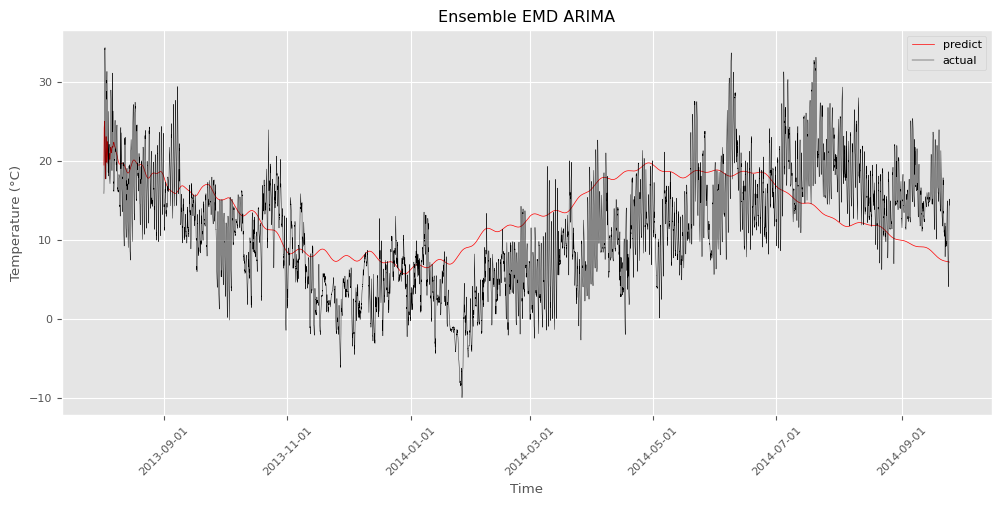

In [16]:
# Visualizar datos
plt.figure(figsize=(12, 5))
plt.plot(test.index, imf_eemd_fc, label='predict', color='r', linewidth=0.5)
plt.plot(test.index, test.values, label='actual', color='k', linewidth=0.3)
plt.title('Ensemble EEMD ARIMA')
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend()

# Formatear el eje x para mostrar fechas
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.show()

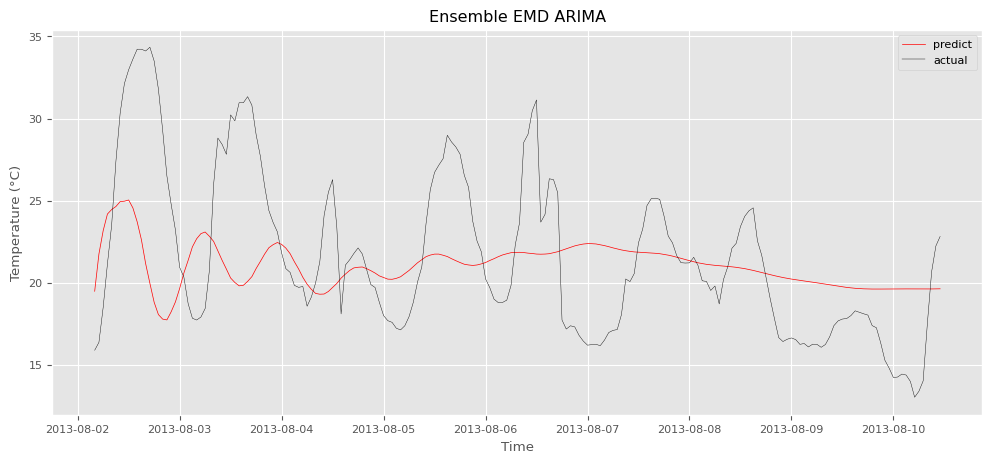

In [26]:
import matplotlib.dates as mdates

test_subset = test[:200]
imf_eemd_fc_subset = imf_eemd_fc[:200]

plt.figure(figsize=(12, 5))
plt.plot(test_subset.index, imf_eemd_fc_subset, label='predict', color='r', linewidth=0.5)
plt.plot(test_subset.index, test_subset.values, label='actual', color='k', linewidth=0.3)
plt.title('Ensemble EMD ARIMA')
plt.xlabel(x_label)
plt.ylabel(y_label)
plt.legend()

In [13]:
# RMSE_EEMD_SVR = mean_squared_error(test, imf_eemd_fc)
MAE_EEMD_SVR  =mean_absolute_error(test, imf_eemd_fc)
MAPE_EEMD_SVR = mean_absolute_percentage_error(test, imf_eemd_fc)
print('MAE = {}'.format(MAE_EEMD_SVR), '\nMAPE = {}'.format(MAPE_EEMD_SVR))

MAE = 5.508806615084995 
MAPE = 9090334354799.385
